## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols

from helper.project_helper import NoOverlapVoter

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
universe_raw = pd.read_csv('factor_data/all_zscore_20180405_20230327.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)

# only use from 2022.3 to 2023.3, here from 20220201 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20220305]
universe.columns

Index(['ts_code', 'trade_date', 'turnover_rate', 'pe', 'pb', 'total_share',
       'free_share', 'total_mv', 'circ_mv', 'name', 'industry', 'list_date',
       'volume', 'amount', 'open', 'close', 'high', 'low', 'rsi_6', 'rsi_12',
       'ann_date', 'type', 'p_change_min', 'p_change_max', 'issue_price',
       'issue_amount', 'cfps', 'revenue_ps', 'gross_margin', 'dt_eps',
       'dt_eps_yoy', 'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt',
       'roe_yoy', 'ebt_yoy', 'or_yoy', 'alpha_close2open', 'supertrend',
       'close_5_sma', 'turnover_rate_5_sma', 'log-ret', 'atr_5', 'ppo',
       'cci_6', 'wr_6', 'close_10_kama_2_30', 'alpha_close2open_25_sma',
       'close_10_kama_2_30.1', 'alpha_supertrend', 'alpha_cci', 'alpha_winlos',
       'alpha_peg', 'alpha_turnover', 'alpha_volume', 'alpha_skew2sentiment',
       'alpha_kama', 'alpha_ppo'],
      dtype='object')

In [3]:
sector_dict = {'化学制药':1, '医药商业':2, '中成药':3, '生物制药':4}

all_factors = universe.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

### Add and Process AI Factor by Random Forest Model

In [4]:
import joblib

features = [ 
            'pb', 'free_share', 'cfps', 'dt_eps', 'bps', 
            'bps_yoy', 'roe_yoy', 'ebt_yoy', 'or_yoy', 'dt_eps_yoy',
            'alpha_close2open_25_sma', 'alpha_supertrend', 'alpha_cci', 'alpha_winlos',
            'alpha_skew2sentiment', 'alpha_turnover', 'alpha_volume', 'alpha_ppo',
            ] + sector_columns

clf_load = joblib.load('AI_data/clf_20230401.pkl') 
alpha_score = clf_load.predict_proba(all_factors[features]).dot(np.array([-1, 0, 1]))
all_factors['alpha_AI'] = alpha_score
all_factors['alpha_pb'] = -all_factors['pb']
print(alpha_score, len(alpha_score))

[ 0.00627572 -0.01093388 -0.01273    ...  0.0145934   0.01684327
  0.00409083] 16430


In [5]:
# zscore AI factor
from scipy.stats import zscore
all_factors[['alpha_AI_check','cfps']] = all_factors.groupby('date')[['alpha_AI','cfps']].apply(zscore).fillna(0)
all_factors = all_factors.rename({'alpha_AI' : 'AI'}, axis='columns')
all_factors = all_factors.sort_values(by=['date'])

In [6]:
features = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_volume', 'alpha_ppo', 'alpha_pb', 'alpha_skew2sentiment','alpha_winlos', 'AI', 'alpha_AI_check']
universe = all_factors.copy(deep=True)[features]
universe.head()

,ts_code,trade_date,name,industry,close,log-ret,alpha_volume,alpha_ppo,alpha_pb,alpha_skew2sentiment,alpha_winlos,AI,alpha_AI_check
date,,,,,,,,,,,,,
2022-03-07,603520.SH,20220307,司太立,化学制药,39.34521,-0.021827,-0.531665,-0.130848,-2.904346,0.149405,-0.296622,0.006276,-0.347715
2022-03-07,300016.SZ,20220307,北陆药业,中成药,8.25929,-0.017805,1.000347,-0.079087,0.849672,-2.382815,0.288756,0.014966,0.136117
2022-03-07,002873.SZ,20220307,新天药业,中成药,16.35542,0.028146,-2.011776,-2.016985,-0.409068,-0.092111,-3.422224,-0.028539,-2.285964
2022-03-07,002082.SZ,20220307,万邦德,中成药,10.81000,-0.051386,0.871444,1.198562,0.724301,-0.887512,0.128986,0.019938,0.412921
2022-03-07,600750.SH,20220307,江中药业,中成药,11.64039,-0.015786,0.925301,0.133153,1.102929,1.067500,0.285390,0.028743,0.903132


In [7]:
## fill data to history by 0 in order to get same init holding size
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                data = [pd.to_datetime(dt, format='%Y%m%d'),ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0., 0., 0.,0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|█████████████████████████████████████████| 258/258 [00:12<00:00, 20.54it/s]


In [8]:
universe.head()

,ts_code,trade_date,name,industry,close,log-ret,alpha_volume,alpha_ppo,alpha_pb,alpha_skew2sentiment,alpha_winlos,AI,alpha_AI_check
date,,,,,,,,,,,,,
2022-03-07,603520.SH,20220307,司太立,化学制药,39.34521,-0.021827,-0.531665,-0.130848,-2.904346,0.149405,-0.296622,0.006276,-0.347715
2022-03-07,300683.SZ,20220307,海特生物,生物制药,51.41,-0.026868,0.2221,0.628393,0.177602,-0.252813,0.764596,0.024348,0.658411
2022-03-07,603669.SH,20220307,灵康药业,化学制药,8.14701,-0.013214,0.928406,0.717283,-1.190458,0.23637,0.225445,0.022424,0.551347
2022-03-07,603590.SH,20220307,康辰药业,化学制药,28.4752,-0.023013,0.728353,0.484315,0.865996,0.381069,0.233455,0.037763,1.405307
2022-03-07,603538.SH,20220307,美诺华,化学制药,23.59232,0.000907,-1.887617,0.007731,-0.124042,0.258454,0.368832,-0.017731,-1.684267


In [9]:
# stay 5 days of holding
# def skip_ndays_trading(df, n_days):
#     def get_return(data):
#         return (data.shift(-1) - data)/(data + 1e-4)
#     trading_calendar = df.trade_date.unique()[::n_days]
#     df = df.loc[df.trade_date.isin(trading_calendar)]
#     df['pct_chg'] = df.groupby('ts_code')['close'].apply(get_return)
#     return df.dropna().sort_values(by=['date'])

# tmp = skip_ndays_trading(universe, 5)
# print(tmp.shape, universe.shape)
# print(tmp.trade_date.unique())
# tmp

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [11]:
## shif return 2 times
all_factors = universe.copy(deep=True)
all_factors = all_factors.sort_values(by=['date'])
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.)
all_factors['returns_2'] = all_factors.groupby('ts_code')['log-ret'].shift(-2).fillna(method='ffill')

## lean data
#all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
#all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
#all_factors.reset_index(inplace=True)
#all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
#all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

print(universe.shape, all_factors.shape)

(18060, 13) (18060, 14)


In [12]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    form = get_formula(all_factors, "returns_2")
    model = ols(form, data=estu)
    results = model.fit()
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220505]).params

alpha_volume            0.000965
alpha_ppo              -0.001892
alpha_pb                0.000879
alpha_skew2sentiment   -0.003437
alpha_winlos           -0.002935
alpha_AI_check         -0.000586
dtype: float64

In [13]:
calendar = all_factors.trade_date.unique() # int64
facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(all_factors.loc[all_factors['trade_date']==dt]).params
facret[calendar[-1]]

regression factor returns: 100%|██████████████| 258/258 [00:03<00:00, 81.56it/s]


alpha_volume           -2.439455e-18
alpha_ppo              -8.673617e-19
alpha_pb                4.228388e-18
alpha_skew2sentiment   -2.493665e-18
alpha_winlos           -1.626303e-19
alpha_AI_check          4.336809e-19
dtype: float64

#### Veiw Factor Returns

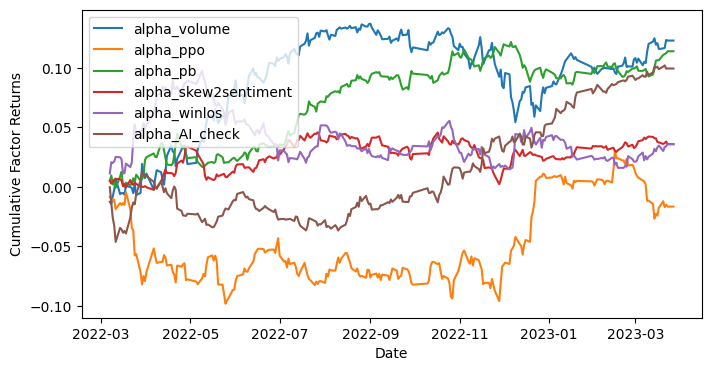

In [14]:
date_list = all_factors.index.unique()
facret_df = pd.DataFrame(index = date_list)
alpha_field = factors_from_names(list(all_factors), 'alpha_')

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    if column != 'alpha_AI':
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### PCA model
We use PCA algorithm to estimate risk

In [15]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=252):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, 
                                            self.factor_returns_, self.factor_betas_, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [16]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 5
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    f = rm.factor_returns_
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, f, rm.idiosyncratic_var_vector

# test
start_time = 20220315
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
df.loc[df.index[-1],'trade_date'].unique()[-1]
print(f'return date {dt}')
variance_i.head()

pca window_len is 6
return date 20220315


ts_code,000028.SZ,000153.SZ,000411.SZ,000705.SZ,000756.SZ,000915.SZ,000952.SZ,002082.SZ,002365.SZ,002393.SZ,...,688117.SH,688163.SH,688189.SH,688317.SH,688553.SH,688566.SH,688656.SH,688658.SH,688687.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000028.SZ,5.042189e-32,-6.365519e-33,-4.726108e-17,-4.297855e-17,-1.635783e-17,-2.439187e-17,1.868695e-17,3.566132e-17,-1.284597e-17,-7.743975e-17,...,0.0,0.0,6.385564e-18,0.0,0.0,2.703893e-17,0.0,4.961568e-18,0.0,0.0
000153.SZ,-6.365519e-33,9.702313e-31,-3.981573e-16,-2.389862e-16,-5.416646e-16,-4.813820e-16,-3.186692e-16,-3.486520e-16,-1.833201e-16,-5.819594e-16,...,0.0,0.0,-4.300928e-16,0.0,0.0,-1.463836e-16,0.0,-3.398844e-16,0.0,0.0
000411.SZ,-4.726108e-17,-3.981573e-16,5.951779e-01,6.561396e-01,5.998526e-01,6.057615e-01,3.352869e-01,2.609804e-01,2.482380e-01,4.645979e-01,...,0.0,0.0,4.125089e-01,0.0,0.0,1.138376e-01,0.0,3.483839e-01,0.0,0.0
000705.SZ,-4.297855e-17,-2.389862e-16,6.561396e-01,1.188148e+00,6.232887e-01,7.039327e-01,4.105791e-01,2.371225e-01,2.981817e-01,7.672361e-02,...,0.0,0.0,4.011957e-01,0.0,0.0,1.439328e-01,0.0,3.724593e-01,0.0,0.0
000756.SZ,-1.635783e-17,-5.416646e-16,5.998526e-01,6.232887e-01,7.139987e-01,6.774484e-01,4.232679e-01,3.834129e-01,2.722400e-01,5.599876e-01,...,0.0,0.0,5.152481e-01,0.0,0.0,1.777165e-01,0.0,4.262245e-01,0.0,0.0


In [17]:
start_time = 20220315
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.mean(axis=0)]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 6
(17640, 3) (17640, 15)


### Combine AlphaFactors

In [24]:
print(max(all_factors['alpha_volume']), min(all_factors['alpha_volume']))
print(max(all_factors['alpha_pb']), min(all_factors['alpha_pb']))
print(all_factors['alpha_volume'].mean())

1.888864813176962 -1.888864813176962
1.949729505339392 -1.949729505339392
0.07115493291260512


In [23]:
all_factors['alpha_volume'] = wins(all_factors['alpha_volume'], -all_factors['alpha_volume'].max(), all_factors['alpha_volume'].max())
all_factors['alpha_pb'] = wins(all_factors['alpha_pb'], -all_factors['alpha_pb'].max(), all_factors['alpha_pb'].max())


In [25]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors['alpha_AI'] = all_factors['AI']
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code'])

alpha_df['alpha_all'] = (0.5 * alpha_df['alpha_AI'] / alpha_df['alpha_AI'].max()
                         + 0.3*alpha_df['alpha_volume'] / alpha_df['alpha_volume'].max() 
                         + 0.2*alpha_df['alpha_pb'] / alpha_df['alpha_pb'].max())
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))
alpha_df['alpha_all'] = alpha_df['alpha_all']/max(abs(alpha_df['alpha_all']))
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

0.6363226583265773 -0.7741361888882199
0.8219776667984424 -1.0


### Backtesting

In [30]:
# the lambda expressed a transfer costs can't endure, the larger the more we reject.
def get_obj_func(h0, variance, alpha, Lambda=3e-3, aversion=1.): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + 0.5 * aversion * np.dot(h, variance).dot(h.T) \
             + Lambda * abs((h-h0))
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-3, aversion=1.):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) \
                + Lambda
        return f_hat
    return grad_func

# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1

#start_time = 20220315
alpha_df['h_privious'] = 0.
positions = {}
calendar = alpha_df.trade_date.unique()

# get parameter
ticker_num = len(alpha_df.index.get_level_values(1).unique())
h0 = [0.] * ticker_num
bounds = [(0,1)] * ticker_num

for dt in calendar:
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
    # convex optimize
    obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    # update optimize holding
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal
    

41.53729973856787 7.113893741809391


<AxesSubplot:>

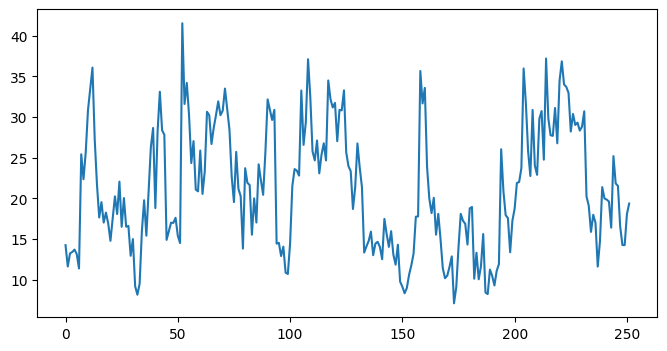

In [31]:
all_positions = []
for dt in positions.keys():
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
#positions[20230315]['h_opt'].hist()
pd.Series(all_positions).plot()

In [33]:
for i in positions.keys():
    positions[i]['h_opt'] = positions[i]['h_opt']/(positions[i]['h_opt'].sum()+1e-5)
    positions[i]['h_privious'] = positions[i]['h_privious']/(positions[i]['h_privious'].sum()+1e-5)
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

0.9999997592525837 0.9999985943020369


<AxesSubplot:>

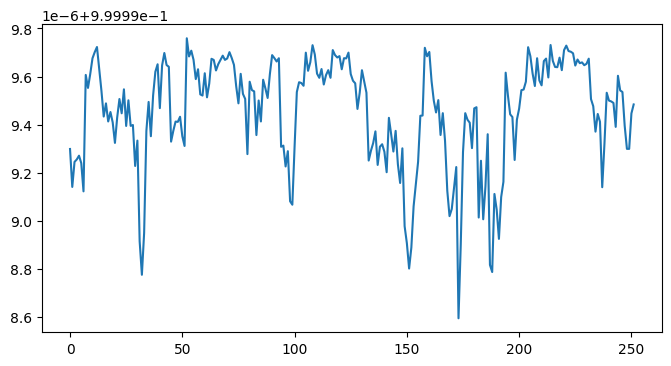

In [34]:
all_positions = []
for dt in positions.keys():
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
#positions[20230315]['h_opt'].hist()
pd.Series(all_positions).plot()

## Calculate Exposure and Transaction Costs

### risk exposure
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

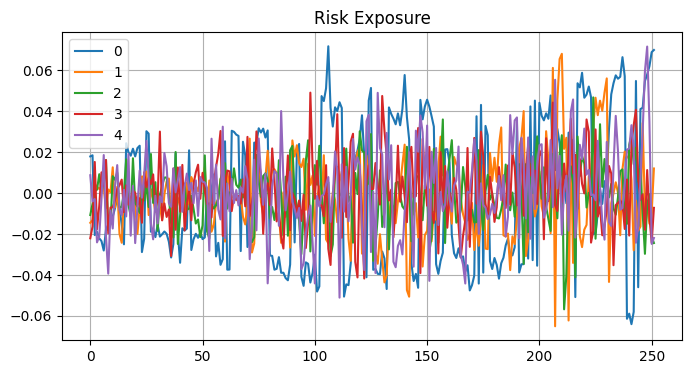

In [35]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### alpha exposure

In [36]:
all_factors.head()

,ts_code,trade_date,name,industry,close,log-ret,alpha_volume,alpha_ppo,alpha_pb,alpha_skew2sentiment,alpha_winlos,AI,alpha_AI_check,returns_2,residual,date,alpha_AI
0,600993.SH,20220315,马应龙,中成药,19.87309,-0.069818,0.860977,0.813657,0.493083,0.304399,0.155545,0.023081,0.629694,0.043700,0.004855,2022-03-15,0.023081
1,002728.SZ,20220315,特一药业,中成药,15.17359,0.000628,-0.037144,-0.872156,0.427123,-0.240947,0.333489,-0.000041,-0.545964,0.036984,0.035339,2022-03-15,-0.000041
2,300871.SZ,20220315,回盛生物,生物制药,20.17661,-0.083674,0.577358,0.501989,0.338878,-1.707394,-0.813897,0.007038,-0.186025,0.052202,0.067450,2022-03-15,0.007038
3,603351.SH,20220315,威尔药业,化学制药,27.89146,-0.025495,0.013849,0.437549,-0.121362,0.228007,-2.696604,0.017015,0.321262,0.018031,0.000361,2022-03-15,0.017015
4,002082.SZ,20220315,万邦德,中成药,9.73000,-0.054986,1.287487,1.706134,0.870329,1.041337,0.715234,0.025509,0.753138,0.008008,0.013115,2022-03-15,0.025509


<AxesSubplot:>

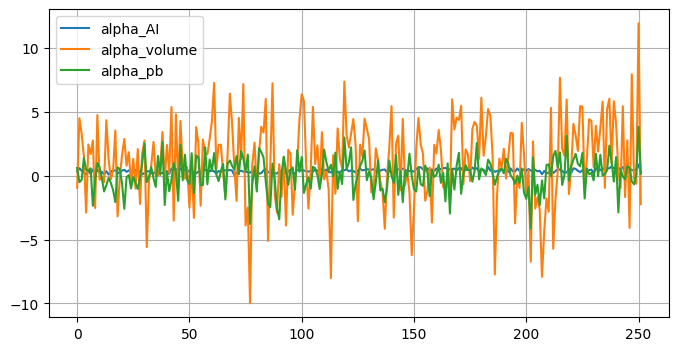

In [57]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for dt in calendar:
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code','alpha_AI', 'alpha_volume', 'alpha_pb' ,'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    # divide 2 almost close to max(alpha_df['alpha_all'])
    
    B_alpha = B_alpha * [[0.6, 0.3, 0.1]] * len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_AI', 'alpha_volume', 'alpha_pb'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.plot(grid=True)

In [38]:
alpha_exposure_df

,alpha_AI,alpha_volume,alpha_pb
0,0.323566,-0.932536,0.607375
1,0.594321,4.512731,-0.504760
2,0.389700,3.287366,-0.319395
3,0.261348,1.528735,1.390495
4,0.099923,-2.881483,0.472479
...,...,...,...
247,0.445460,7.949761,-0.438160
248,0.424581,-0.195591,-0.672725
249,0.498171,-0.633465,0.082298
250,0.881329,11.944416,3.833047


### Transaction Costs

In [39]:
transaction_costs = []
Lambda = 3e-3
for i in range(len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    costs = sum(np.dot(tmp_change.values**2, Lambda))
    transaction_costs.append(costs)
print(sum(transaction_costs))

0.039521239246334924


## Profit-and-Loss (PnL) 

In [40]:
#all_factors.head()
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

In [41]:
all_factors.index.unique()[0]

Timestamp('2022-03-15 00:00:00')

2023-03-27 00:00:00


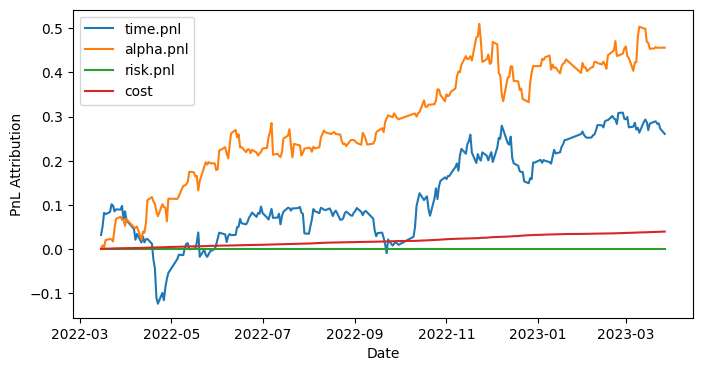

In [69]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d'))
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        fr = facret[dt][[0,2,5]]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"cost"] = transaction_costs[ii]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [68]:
facret[dt][[0,2,5]]
#alpha_exposures[dt]

alpha_volume     -2.439455e-18
alpha_pb          4.228388e-18
alpha_AI_check    4.336809e-19
dtype: float64

In [44]:
attr['alpha.pnl'].sum()

0.4560507224120178

In [45]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d'))
    calendar = all_factors.trade_date.unique()
    for ii,dt in zip(calendar, df.index):
        p = positions[ii]

        df.at[dt,"long"] = np.sum([_ for _ in p['h_opt'] if _ > 0])
        # df.at[dt,"short"] = np.sum([_ for _ in h if _ < 0])
        df.at[dt,"net"] = np.sum(p['h_opt'])
        df.at[dt,"gmv"] = np.sum(abs(p['h_opt']))
        df.at[dt,"traded"] = np.sum(abs(p['h_opt'] - p['h_privious']))
        
    return df

                long       net       gmv    traded
2023-03-21  0.999999  0.999999  0.999999  0.978702
2023-03-22  0.999999  0.999999  0.999999  1.181026
2023-03-23  0.999999  0.999999  0.999999  1.159002
2023-03-24  0.999999  0.999999  0.999999  1.438654
2023-03-27  0.999999  0.999999  0.999999  1.444945


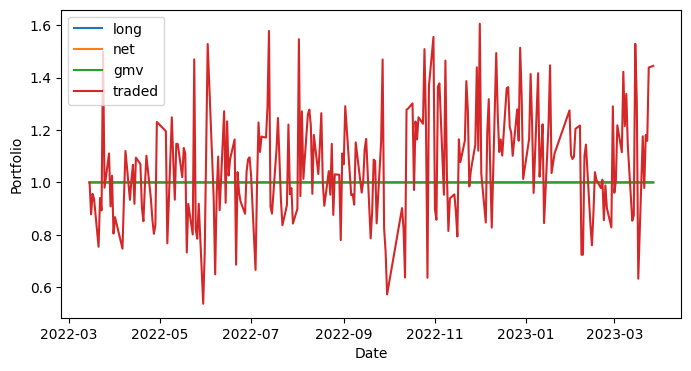

In [46]:
pchar = build_portfolio_characteristics()
print(pchar.tail())
for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()